# Sprint 12: Proyecto del módulo 2
Prepara un prototipo de un modelo de machine learning para Zyfra. La empresa desarrolla soluciones de eficiencia para la industria pesada.

El modelo debe predecir la cantidad de oro extraído del mineral de oro. Dispones de los datos de extracción y purificación.

El modelo ayudará a optimizar la producción y a eliminar los parámetros no rentables.

Tendrás que:

- Preparar los datos.
- Realizar el análisis de datos.
- Desarrollar un modelo y entrenarlo.

Necesitamos predecir dos valores:

- La recuperación del concentrado rougher rougher.output.recovery.
- La recuperación final del concentrado final.output.recovery.

## Preparación de los datos

### Examinar los datos

In [1]:
# importar librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


In [2]:
# Leer los datasets
df_gold_recovery_train = pd.read_csv('/datasets/gold_recovery_train.csv')
df_gold_recovery_test = pd.read_csv('/datasets/gold_recovery_test.csv')
df_gold_recovery_full = pd.read_csv('/datasets/gold_recovery_full.csv')


In [3]:
# dataset de entrenamiento
#df_gold_recovery_train

In [4]:
# dataset de entrenamiento
#print(df_gold_recovery_train.info())

In [5]:
# dataset de prueba
#df_gold_recovery_test

In [6]:
# dataset de prueba
#print(df_gold_recovery_test.info())

In [7]:
# dataset full
#df_gold_recovery_full

In [8]:
# dataset full
print(df_gold_recovery_full.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


In [9]:
# revisar valores duplicados
print(df_gold_recovery_train.duplicated().sum())
print(df_gold_recovery_test.duplicated().sum())
print(df_gold_recovery_full.duplicated().sum())

0
0
0


In [10]:
print(df_gold_recovery_full['final.output.concentrate_au'].isna().sum())

86


### Cálculo de recuperación


In [11]:
df_gold_recovery_train = df_gold_recovery_train.dropna(how='any', subset=['rougher.output.concentrate_au', 'rougher.input.feed_au', 'rougher.output.tail_au']).reset_index()
#df_gold_recovery_train.info()

In [12]:
# Comprueba que el cálculo de la recuperación en el conjunto de entrenamiento sea correcto

C = df_gold_recovery_train['rougher.output.concentrate_au']
F = df_gold_recovery_train['rougher.input.feed_au']
T = df_gold_recovery_train['rougher.output.tail_au']

df_gold_recovery_train['calculo_recuperación'] = ((C*(F-T))/(F*(C-T))*100)

# encuentra el EAM entre el cálculo y el valor de la característica
#EAM = (mean_absolute_error(df_gold_recovery_train['rougher.output.recovery'].astype(float), df_gold_recovery_train['calculo_recuperación'].astype(float)))
EAM = abs(df_gold_recovery_train['rougher.output.recovery'] - df_gold_recovery_train['calculo_recuperación']).sum()
print("Error abosluto medio: ", EAM)
df_gold_recovery_train[['rougher.output.recovery','calculo_recuperación']]

Error abosluto medio:  1.3291789890956807e-10


,rougher.output.recovery,calculo_recuperación
0,87.107763,87.107763
1,86.843261,86.843261
2,86.842308,86.842308
3,87.226430,87.226430
4,86.688794,86.688794
...,...,...
14605,89.574376,89.574376
14606,87.724007,87.724007
14607,88.890579,88.890579
14608,89.858126,89.858126


El cálculo es correcto.

### Características ausentes en conjunto de prueba

In [13]:
# obtener las columnas de cada DataFrame
train_columns = set(df_gold_recovery_train.columns)
test_columns = set(df_gold_recovery_test.columns)

# encontrar las columnas que están en train pero no en test
missing_columns = sorted(train_columns - test_columns)

# muestra las columnas faltantes
print("Columnas ausentes en df_gold_recovery_test:\n")
for col in missing_columns:
    print(f"- {col}")

#print("Total de columnas:", len(df_gold_recovery_train.columns)-len(df_gold_recovery_test.columns))

Columnas ausentes en df_gold_recovery_test:

- calculo_recuperación
- final.output.concentrate_ag
- final.output.concentrate_au
- final.output.concentrate_pb
- final.output.concentrate_sol
- final.output.recovery
- final.output.tail_ag
- final.output.tail_au
- final.output.tail_pb
- final.output.tail_sol
- index
- primary_cleaner.output.concentrate_ag
- primary_cleaner.output.concentrate_au
- primary_cleaner.output.concentrate_pb
- primary_cleaner.output.concentrate_sol
- primary_cleaner.output.tail_ag
- primary_cleaner.output.tail_au
- primary_cleaner.output.tail_pb
- primary_cleaner.output.tail_sol
- rougher.calculation.au_pb_ratio
- rougher.calculation.floatbank10_sulfate_to_au_feed
- rougher.calculation.floatbank11_sulfate_to_au_feed
- rougher.calculation.sulfate_to_au_concentrate
- rougher.output.concentrate_ag
- rougher.output.concentrate_au
- rougher.output.concentrate_pb
- rougher.output.concentrate_sol
- rougher.output.recovery
- rougher.output.tail_ag
- rougher.output.tail_au

Las características no disponibles en el conjunto de prueba son: los concentrados y colas de plata, oro, plomo y otras impurezas, tanto finales como después de cada etapa como rougher, primary cleaner, secondary cleaner (de este último solo existen los concentrados).

Todas estas son de tipo flotante.

### Preprocesamiento de datos

In [14]:
# rellenar valores nulos de cada columna con el promedio 
df_gold_recovery_train = df_gold_recovery_train.fillna(df_gold_recovery_train.mean(numeric_only=True))
df_gold_recovery_test = df_gold_recovery_test.fillna(df_gold_recovery_test.mean(numeric_only =True))
df_gold_recovery_full = df_gold_recovery_full.fillna(df_gold_recovery_full.mean(numeric_only=True))
df_gold_recovery_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22716 non-null  float64
 2   final.output.concentrate_pb                         22716 non-null  float64
 3   final.output.concentrate_sol                        22716 non-null  float64
 4   final.output.concentrate_au                         22716 non-null  float64
 5   final.output.recovery                               22716 non-null  float64
 6   final.output.tail_ag                                22716 non-null  float64
 7   final.output.tail_pb                                22716 non-null  float64
 8   final.output.tail_sol                               22716 non-null  float64


In [15]:
# revisar duplicados

print(df_gold_recovery_train.duplicated().sum())
print(df_gold_recovery_test.duplicated().sum())
print(df_gold_recovery_full.duplicated().sum())

0
0
0


## Análisis de los datos

### Concentración de metales
Observa cómo cambia la concentración de metales (Au, Ag, Pb) en función de la etapa de purificación.

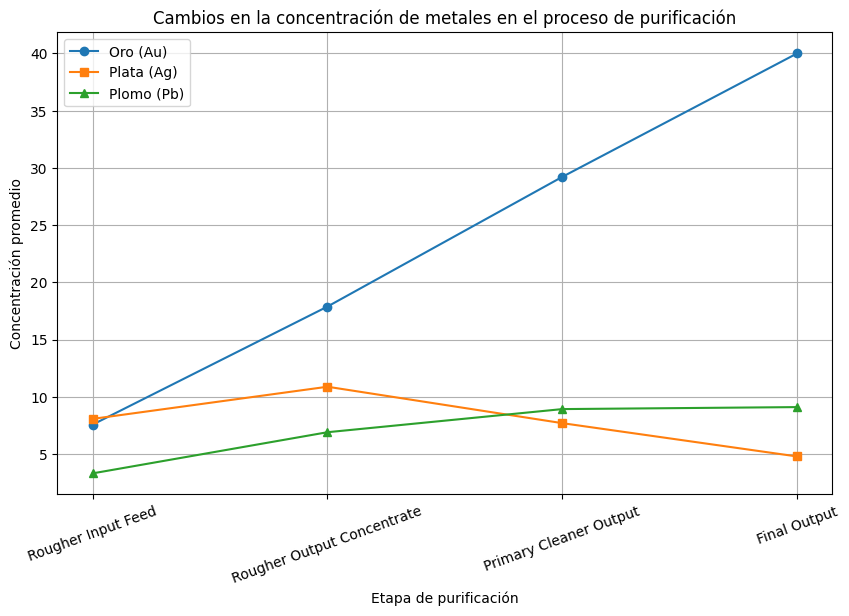

In [16]:
# nombre de las etapas de concentración
stages = ["Rougher Input Feed", "Rougher Output Concentrate", "Primary Cleaner Output", "Final Output"]

# promediar las concentraciones en cada etapa
au_concentration = [
    df_gold_recovery_full["rougher.input.feed_au"].mean(),
    df_gold_recovery_full["rougher.output.concentrate_au"].mean(),
    df_gold_recovery_full["primary_cleaner.output.concentrate_au"].mean(),
    df_gold_recovery_full["final.output.concentrate_au"].mean()]

ag_concentration = [
    df_gold_recovery_full["rougher.input.feed_ag"].mean(),
    df_gold_recovery_full["rougher.output.concentrate_ag"].mean(),
    df_gold_recovery_full["primary_cleaner.output.concentrate_ag"].mean(),
    df_gold_recovery_full["final.output.concentrate_ag"].mean()]

pb_concentration = [
    df_gold_recovery_full["rougher.input.feed_pb"].mean(),
    df_gold_recovery_full["rougher.output.concentrate_pb"].mean(),
    df_gold_recovery_full["primary_cleaner.output.concentrate_pb"].mean(),
    df_gold_recovery_full["final.output.concentrate_pb"].mean()]

# crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(stages, au_concentration, marker='o', label='Oro (Au)')
plt.plot(stages, ag_concentration, marker='s', label='Plata (Ag)')
plt.plot(stages, pb_concentration, marker='^', label='Plomo (Pb)')

plt.xlabel("Etapa de purificación")
plt.ylabel("Concentración promedio")
plt.title("Cambios en la concentración de metales en el proceso de purificación")
plt.legend()
plt.grid(True)

# mostrar la gráfica
plt.xticks(rotation=20)
plt.show()

Se observa que a medida que avanza el proceso de purificación, la concentración de oro aumenta mientras que la de plomo y plata disminuye o se mantiene en los niveles del inicio.

### Análisis del tamaño de las partículas de la alimentación
Compara las distribuciones del tamaño de las partículas de la alimentación en el conjunto de entrenamiento y en el conjunto de prueba.

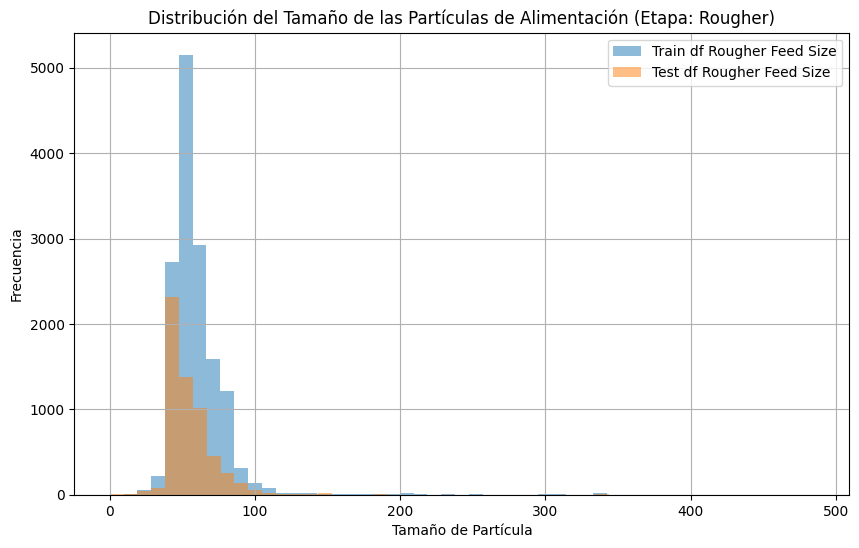

In [17]:
# rougher input feed size de ambos dataset
#df_gold_recovery_train['rougher.input.feed_size'] = df_gold_recovery_train['rougher.input.feed_size'].dropna().reset_index()
#df_gold_recovery_test['rougher.input.feed_size'] = df_gold_recovery_test['rougher.input.feed_size'].dropna().reset_index()


# crear histograma
plt.figure(figsize=(10, 6))
plt.hist(df_gold_recovery_train['rougher.input.feed_size'], bins=50, alpha=0.5, label="Train df Rougher Feed Size")
plt.hist(df_gold_recovery_test['rougher.input.feed_size'], bins=50, alpha=0.5, label="Test df Rougher Feed Size")

# configurar etiquetas y título
plt.xlabel("Tamaño de Partícula")
plt.ylabel("Frecuencia")
plt.title("Distribución del Tamaño de las Partículas de Alimentación (Etapa: Rougher)")
plt.legend()
plt.grid(True)

# mostrar la gráfica
plt.show()

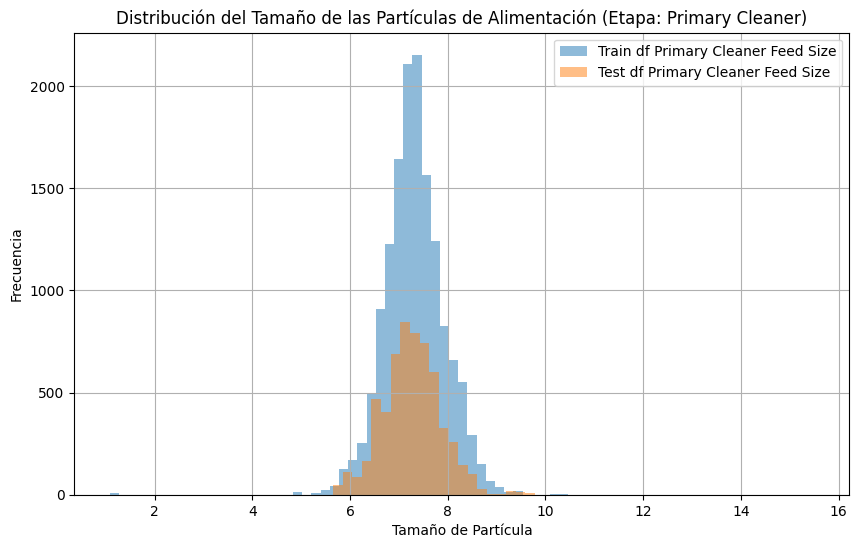

In [18]:
# Primary cleaner input feed size de ambos dataframes
#df_gold_recovery_train['primary_cleaner.input.feed_size'] = df_gold_recovery_train['primary_cleaner.input.feed_size'].dropna().reset_index()
#df_gold_recovery_test['primary_cleaner.input.feed_size'] = df_gold_recovery_test['primary_cleaner.input.feed_size'].dropna().reset_index()


# Crear histograma
plt.figure(figsize=(10, 6))
plt.hist(df_gold_recovery_train['primary_cleaner.input.feed_size'], bins=50, alpha=0.5, label="Train df Primary Cleaner Feed Size")
plt.hist(df_gold_recovery_test['primary_cleaner.input.feed_size'], bins=50, alpha=0.5, label="Test df Primary Cleaner Feed Size")

# Configurar etiquetas y título
plt.xlabel("Tamaño de Partícula")
plt.ylabel("Frecuencia")
plt.title("Distribución del Tamaño de las Partículas de Alimentación (Etapa: Primary Cleaner)")
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show()

In [19]:
print(df_gold_recovery_train['rougher.input.feed_size'].min())
print(df_gold_recovery_train['rougher.input.feed_size'].max())

print(df_gold_recovery_test['rougher.input.feed_size'].min())
print(df_gold_recovery_test['rougher.input.feed_size'].max())

print(df_gold_recovery_train['primary_cleaner.input.feed_size'].min())
print(df_gold_recovery_train['primary_cleaner.input.feed_size'].max())

print(df_gold_recovery_test['primary_cleaner.input.feed_size'].min())
print(df_gold_recovery_test['primary_cleaner.input.feed_size'].max())

9.659576314610517
484.9674664939735
0.0463687988171973
477.44547252313856
1.0800000429153442
10.470000267028809
5.6500000953674325
15.5


Las distribuciones del tamaño de las partículas de alimentación en ambas etapas (rougher y primary cleaner) no varían significativamente entre el dataset de entrenamiento y de prueba. En el dataset de entrenamiento van desde 9.66 a 484.97 para Rougher input mientras que el dataset de prueba va de 0.04 a 477.44; en el dataset de entrenamiento va de 1.08 a 10.47 en Primary Cleaner input y el dataset de prueba de 5.65 a 15.5.

### Análisis de la concentración total de todas las sustancias
Considera las concentraciones totales de todas las sustancias en las diferentes etapas: materia prima, concentrado rougher y concentrado final.

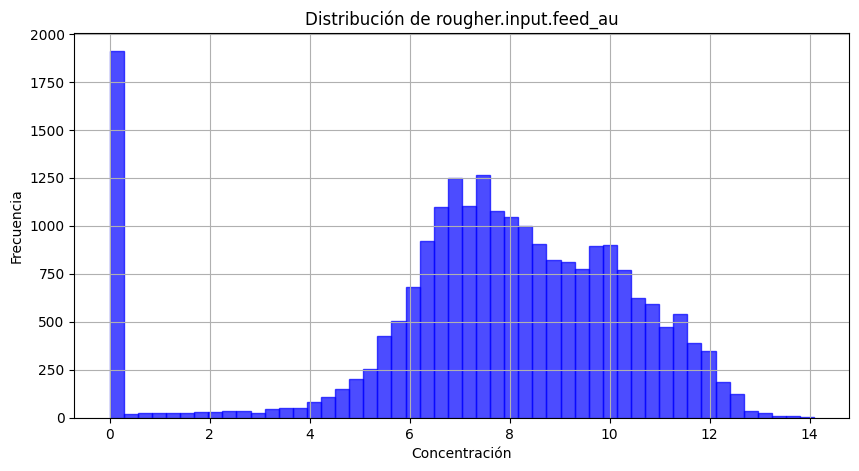

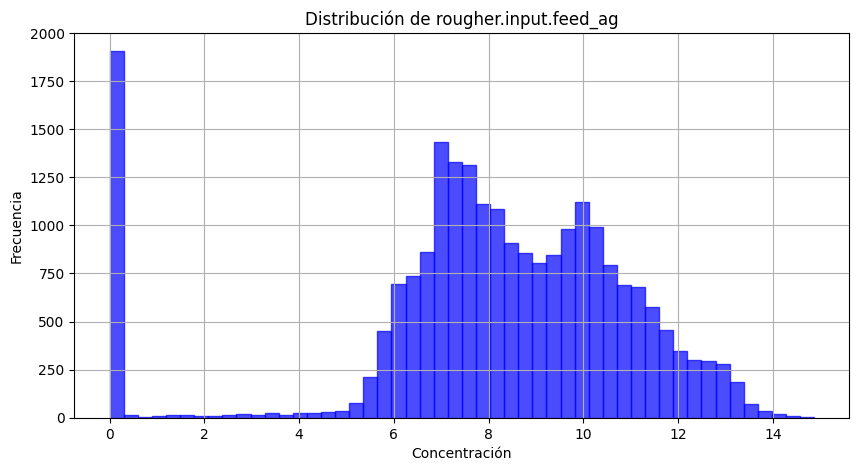

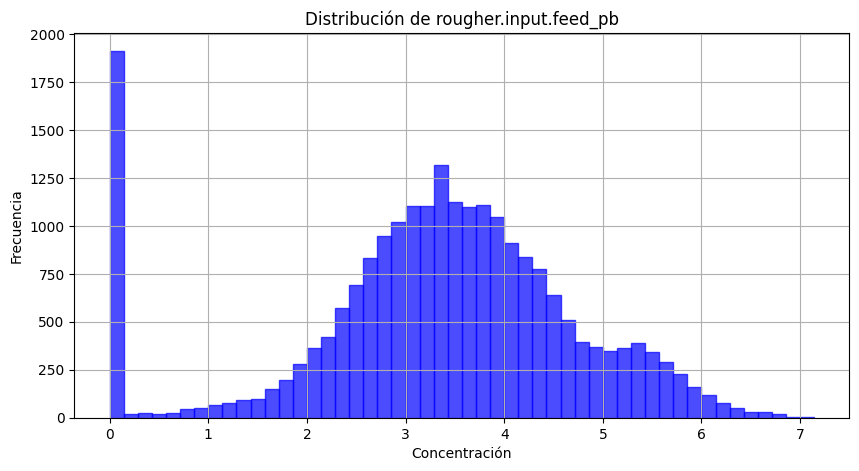

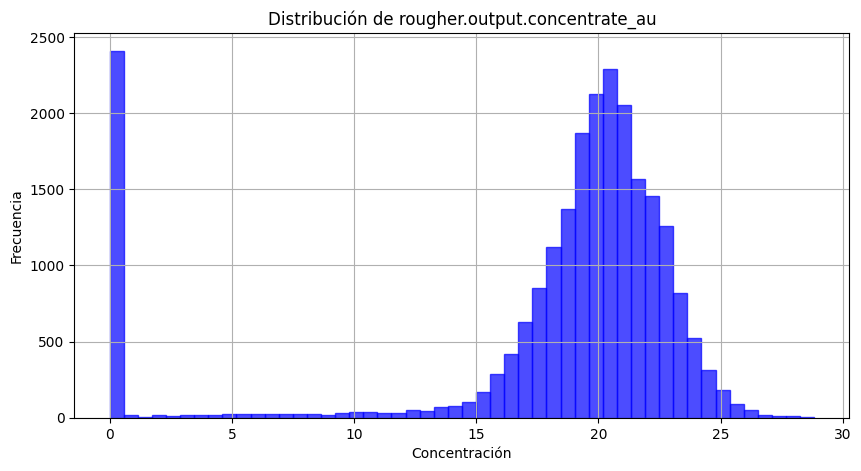

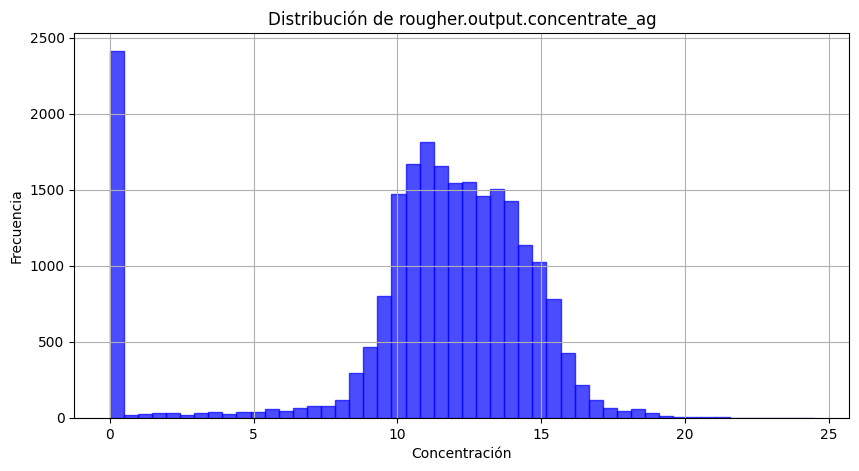

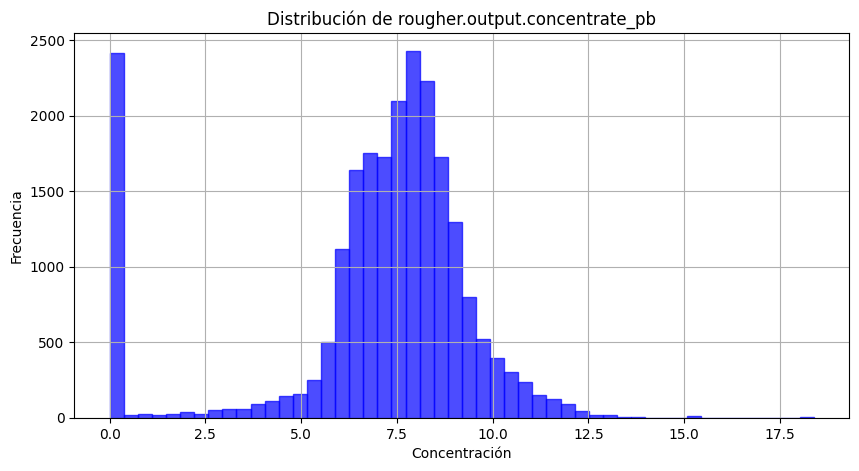

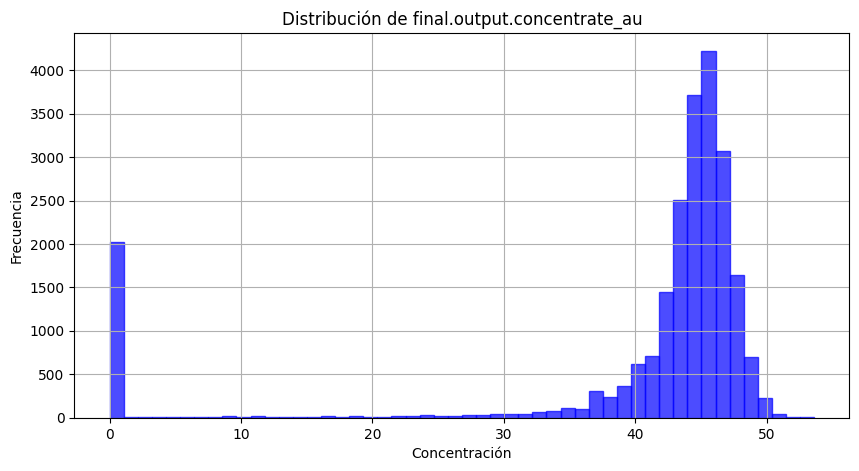

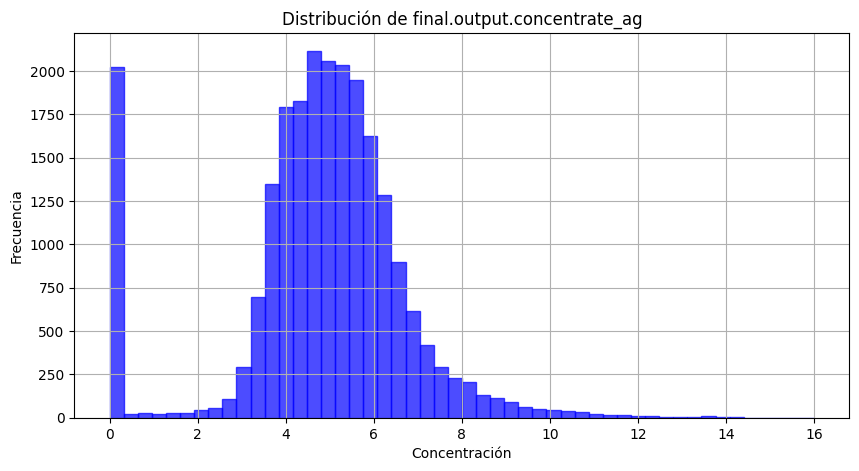

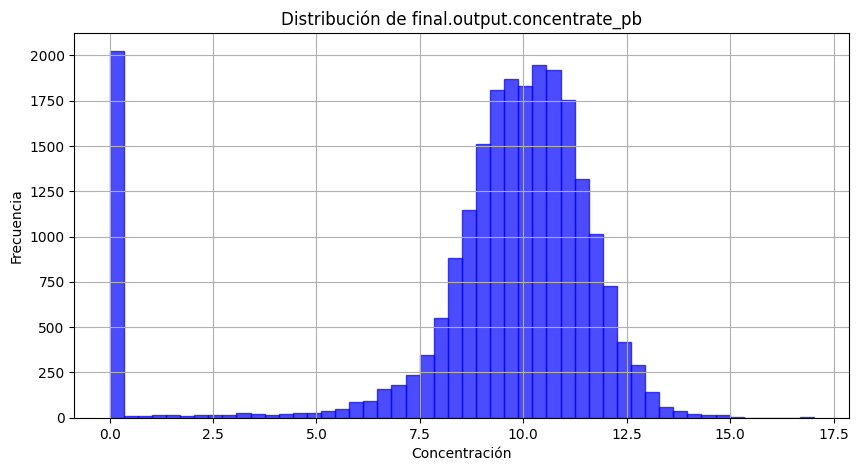

rougher.input.feed_au: 2038 valores atípicos detectados
rougher.input.feed_ag: 1971 valores atípicos detectados
rougher.input.feed_pb: 2021 valores atípicos detectados
rougher.output.concentrate_au: 2907 valores atípicos detectados
rougher.output.concentrate_ag: 2709 valores atípicos detectados
rougher.output.concentrate_pb: 2913 valores atípicos detectados
final.output.concentrate_au: 2959 valores atípicos detectados
final.output.concentrate_ag: 2643 valores atípicos detectados
final.output.concentrate_pb: 2348 valores atípicos detectados


In [20]:
# función crear histogramas para analizar la distribución de las concentraciones
def plot_distribution(column, title):
    plt.figure(figsize=(10, 5))
    plt.hist(df_gold_recovery_full[column], bins=50, alpha=0.7, color='b', edgecolor='blue')
    plt.xlabel("Concentración")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.grid(True)
    plt.show()

#asignar columnas a analizar
columns = df_gold_recovery_full[[
    "rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb",
    "rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb",
    "final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb"]]

for col in columns:
    plot_distribution(col, f"Distribución de {col}")

# detectar valores atípicos
outliers = {}
for col in columns:
    Q1 = df_gold_recovery_full[col].quantile(0.25) # primer cuartil (Q1), 25% de los datos están por debajo de este valor
    Q3 = df_gold_recovery_full[col].quantile(0.75) # tercer cuartil (Q3), 75% de los datos están por debajo de este valor
    IQR = Q3 - Q1 # rango intercuartil
    # define valores atípicos
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    # filtrar valores atípicos
    outliers[col] = df_gold_recovery_full[(df_gold_recovery_full[col] < lower_bound) | (df_gold_recovery_full[col] > upper_bound)][col]

# Mostrar cantidad de valores atípicos detectados
for col, outlier_values in outliers.items():
    print(f"{col}: {len(outlier_values)} valores atípicos detectados")


En todas las gráficas se observan anomalías y una distribución anormal de los datos, especialmente en los valores debajo del primer cuartil. Los demás datos siguen una distribución normal.
Dado esto, se eliminarán los valores cercanos a 0 y se procederá a aplicar normalización a los datos restantes para estandarizar los rangos antes de entrenar el modelo de ML.

In [21]:
# revisar valores cercanos a 0
print(columns.value_counts())

rougher.input.feed_au  rougher.input.feed_ag  rougher.input.feed_pb  rougher.output.concentrate_au  rougher.output.concentrate_ag  rougher.output.concentrate_pb  final.output.concentrate_au  final.output.concentrate_ag  final.output.concentrate_pb
0.000000               0.000000               0.000000               0.000000                       0.000000                       0.000000                       0.000000                     0.000000                     0.000000                       1312
0.010000               0.010000               0.010000               0.010000                       0.010000                       0.010000                       0.010000                     0.010000                     0.010000                        335
0.000000               0.000000               0.000000               0.000000                       0.000000                       0.000000                       36.900124                    6.202827                     10.764648           

In [22]:
columns = [
    "rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb",
    "rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb",
    "final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb"]

df_gold_recovery_full[columns] = df_gold_recovery_full[columns]

#Q1 = df_gold_recovery_full[columns].quantile(0.25)

df_gold_recovery_full_filtered = df_gold_recovery_full[(df_gold_recovery_full[columns] > 0.01).all(axis=1)]

# Verificar las dimensiones
print("Tamaño original:", df_gold_recovery_full.shape)
print("Tamaño después del filtrado:", df_gold_recovery_full_filtered.shape)



Tamaño original: (22716, 87)
Tamaño después del filtrado: (19966, 87)


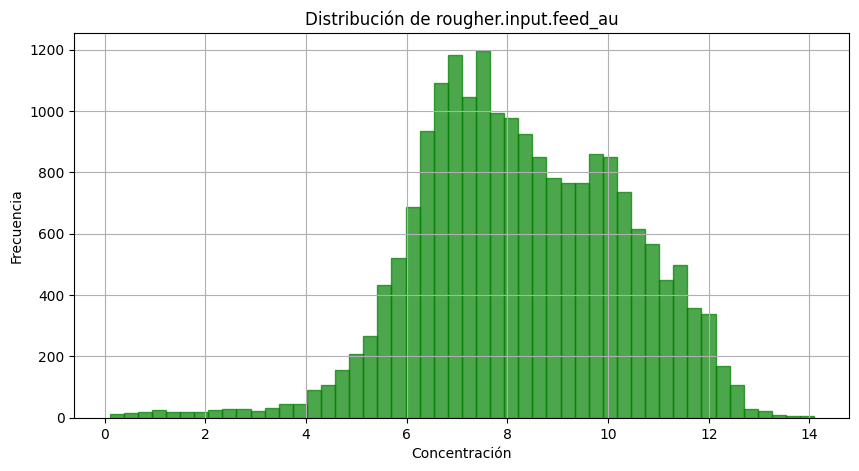

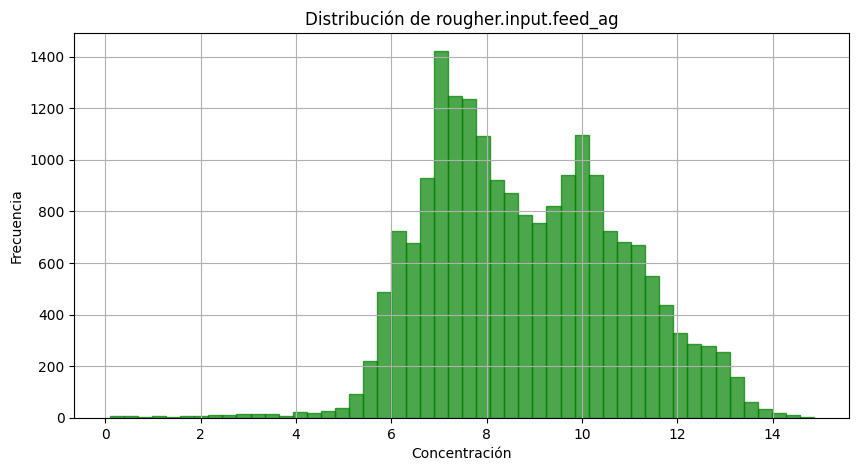

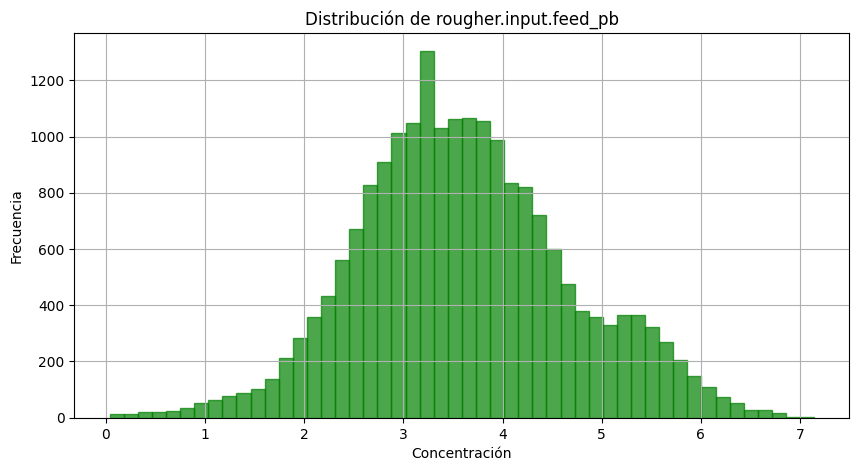

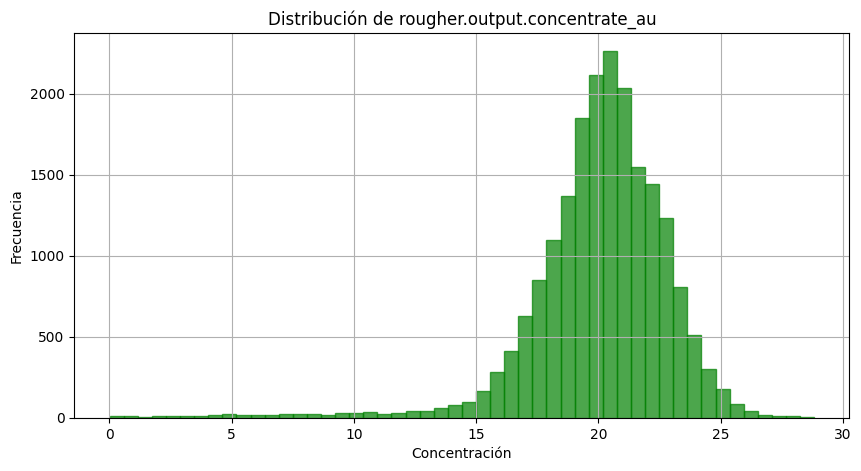

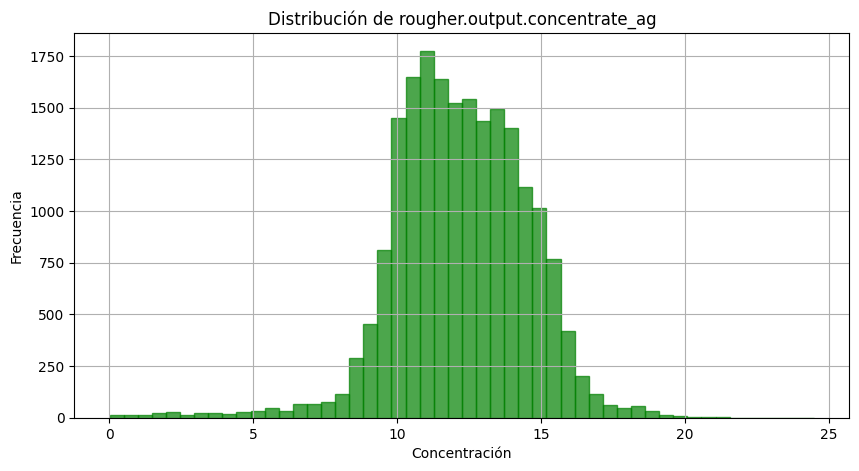

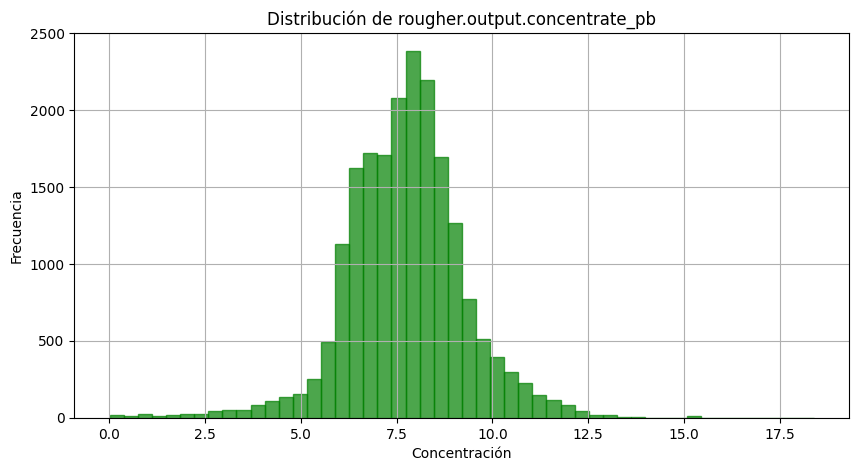

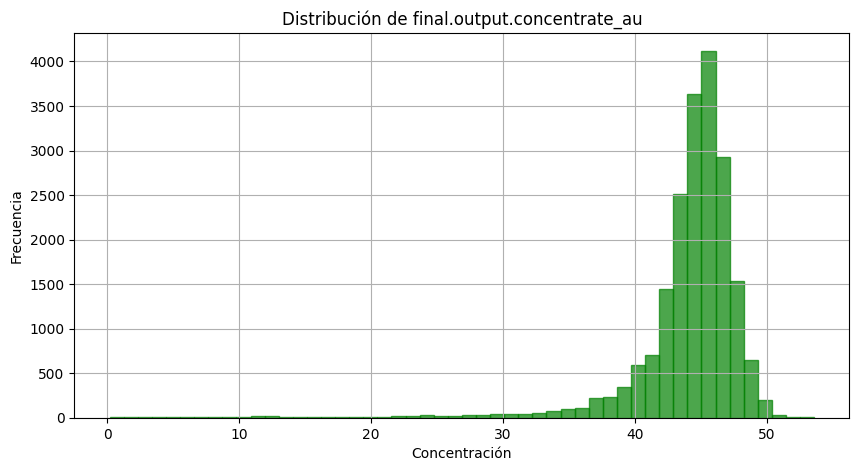

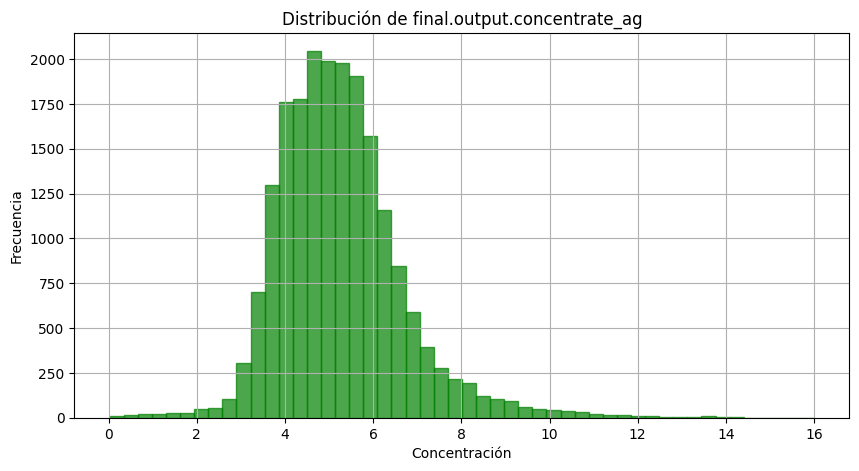

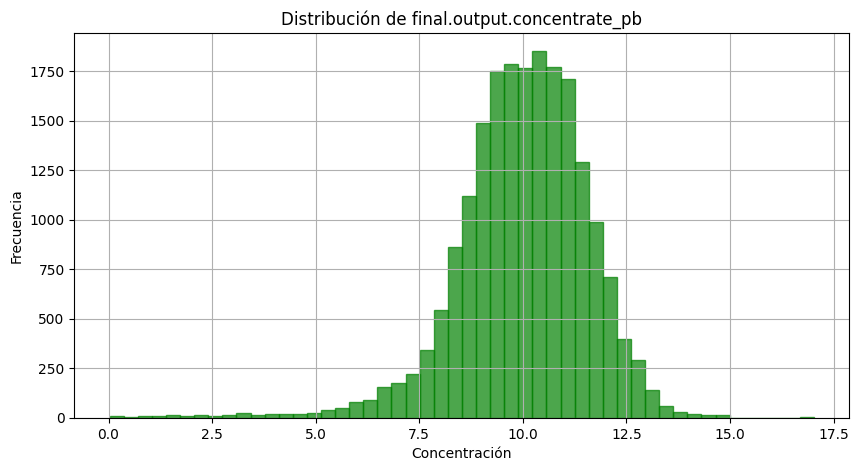

rougher.input.feed_au: 156 valores atípicos detectados
rougher.input.feed_ag: 59 valores atípicos detectados
rougher.input.feed_pb: 208 valores atípicos detectados
rougher.output.concentrate_au: 662 valores atípicos detectados
rougher.output.concentrate_ag: 369 valores atípicos detectados
rougher.output.concentrate_pb: 702 valores atípicos detectados
final.output.concentrate_au: 1328 valores atípicos detectados
final.output.concentrate_ag: 700 valores atípicos detectados
final.output.concentrate_pb: 450 valores atípicos detectados


In [23]:
# analizar las distribuciones nuevamente

# función crear histogramas para analizar la distribución de las concentraciones
def plot_distribution(column, title):
    plt.figure(figsize=(10, 5))
    plt.hist(df_gold_recovery_full_filtered[column], bins=50, alpha=0.7, color='g', edgecolor='green')
    plt.xlabel("Concentración")
    plt.ylabel("Frecuencia")
    plt.title(title)
    plt.grid(True)
    plt.show()

#asignar columnas a analizar
columns = df_gold_recovery_full_filtered[[
    "rougher.input.feed_au", "rougher.input.feed_ag", "rougher.input.feed_pb",
    "rougher.output.concentrate_au", "rougher.output.concentrate_ag", "rougher.output.concentrate_pb",
    "final.output.concentrate_au", "final.output.concentrate_ag", "final.output.concentrate_pb"]]

for col in columns:
    plot_distribution(col, f"Distribución de {col}")

# detectar valores atípicos
outliers = {}
for col in columns:
    Q1 = df_gold_recovery_full_filtered[col].quantile(0.25) # primer cuartil (Q1), 25% de los datos están por debajo de este valor
    Q3 = df_gold_recovery_full_filtered[col].quantile(0.75) # tercer cuartil (Q3), 75% de los datos están por debajo de este valor
    IQR = Q3 - Q1 # rango intercuartil
    # define valores atípicos
    lower_bound = Q1 - 1.5 * IQR 
    upper_bound = Q3 + 1.5 * IQR
    # filtrar valores atípicos
    outliers[col] = df_gold_recovery_full_filtered[(df_gold_recovery_full_filtered[col] < lower_bound) | (df_gold_recovery_full_filtered[col] > upper_bound)][col]

# Mostrar cantidad de valores atípicos detectados
for col, outlier_values in outliers.items():
    print(f"{col}: {len(outlier_values)} valores atípicos detectados")


Después del filtrado quedan significativamente menos valores atípicos en la cola izquierda.

## Modelo de regresión

### Cálculo de sMAPE
Escribe una función para calcular el valor final de sMAPE.

In [24]:
#función sMAPE

def smape_rougher(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

def smape_final(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

#smape(y_true, y_pred)


### Entrenamiento de los modelos

In [25]:
# eliminar columna de fecha

df_gold_recovery_full_filtered = df_gold_recovery_full_filtered.drop('date', axis =1)
#df_gold_recovery_full_filtered.info()

In [26]:
# dividir dataset full en entrenamiento y validación

target = df_gold_recovery_full_filtered[['rougher.output.recovery', 'final.output.recovery']]
features = df_gold_recovery_full_filtered.drop(['rougher.output.recovery', 'final.output.recovery'], axis=1)
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)
features_train = features_train.reset_index(drop=True)
features_valid = features_valid.reset_index(drop=True)
target_train = target_train.reset_index(drop=True)
target_valid = target_valid.reset_index(drop=True)

target_train.columns = [0,1]
target_valid.columns = [0,1]



(14974, 84)
(4992, 84)
(14974, 2)
(4992, 2)


In [27]:
# escalar las medidas numéricas

numeric = features.columns.tolist()

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])


In [28]:
# entrenamiento de regresión linear
kf = KFold(n_splits=4)
model = LinearRegression()

scores=[]

for train_index, valid_index in kf.split(features_train):
    features_subtrain = features_train.loc[train_index].reset_index(drop=True)
    target_subtrain = target_train.loc[train_index].reset_index(drop=True)
    features_subvalid = features_train.loc[valid_index].reset_index(drop=True)
    target_subvalid = target_train.loc[valid_index].reset_index(drop=True)
    model.fit(features_subtrain, target_subtrain)
    
    prediction = pd.DataFrame(model.predict(features_valid))
    
    score_rougher = smape_rougher(target_valid[0], prediction[0])
    
    score_final = smape_final(target_valid[1], prediction[1])
    
    scores.append(score_rougher*0.25 + score_final*0.75)
    

print(sum(scores)/len(scores))

2.7383674816603043


El porcentaje de error medio absoluto porcentual simétrico utilizando la regresión lineal es de 2.74%.

In [29]:
# entrenamiento de bosque aleatorio

model = RandomForestRegressor(n_estimators = 40, max_depth = 10, random_state=12345)
scores=[]

for train_index, valid_index in kf.split(features_train):
    features_subtrain = features_train.loc[train_index].reset_index(drop=True)
    target_subtrain = target_train.loc[train_index].reset_index(drop=True)
    features_subvalid = features_train.loc[valid_index].reset_index(drop=True)
    target_subvalid = target_train.loc[valid_index].reset_index(drop=True)
    model.fit(features_subtrain, target_subtrain)
    
    prediction = pd.DataFrame(model.predict(features_valid))
    
    score_rougher = smape_rougher(target_valid[0], prediction[0])
    
    score_final = smape_final(target_valid[1], prediction[1])
    
    scores.append(score_rougher*0.25 + score_final*0.75)
    

print(sum(scores)/len(scores))


2.397684137406115


El porcentaje de error medio absoluto porcentual simétrico utilizando un bosque aleatorio de 40 estimadores y profundidad de 10 es de 2.40%.

## Conclusión

El porcentaje de error sMAPE utilizando un bosque aleatorio para predecir rougher.output.recovery y final.output.recovery es menor al porcentaje de error sMAPE utilizando la regresión logística.


